### Standard GCN
As in Kipf et al. (2016)

In [364]:
import sys
import os
import time
import argparse
import pdb

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Add higher directory to python modules path.
sys.path.append("..") 
from dataloader import load_cora
from model import GCN

In [365]:
class obj(object):
    def __init__(self, d):
        for a, b in d.items():
            if isinstance(b, (list, tuple)):
               setattr(self, a, [obj(x) if isinstance(x, dict) else x for x in b])
            else:
               setattr(self, a, obj(b) if isinstance(b, dict) else b)
args = {
    'gpu': 1,
    'seed': None,
    'epochs': 500,
    'lr': 0.01,
    'wd': 5e-4,
    'layers': 2,
    'h_size': 16,
    'dropout': 0.5,
    'val_every': -1,
    'val_only': 1,
    'checkpoint': 0,
    'model': 'save/model-val-0.8233.pth',
    'log_every': 50,
    'prepro': '../data/cora/preprocessed.pth',
    'test': 0,
}
args = obj(args)

In [366]:
def dense_to_sparse(x):
    indices = torch.nonzero(x).t()
    values = x[indices[0], indices[1]] # modify this based on dimensionality
    return torch.sparse.FloatTensor(indices, values, x.size())

In [367]:
# Setup
start = time.time()
args.gpu = args.gpu and torch.cuda.is_available() and False
if args.seed is not None:
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.cuda:
        torch.cuda.manual_seed(args.seed)

# Data
if args.prepro:
    tmp = torch.load(args.prepro)
    adj_i, adj_v, adj_s, feats, labels, idx_train, idx_val, idx_test = tmp
    adj = torch.sparse.FloatTensor(adj_i, adj_v, adj_s)
else:
    adj, feats, labels, idx_train, idx_val, idx_test = load_cora()

In [368]:
# Model
model = GCN(num_layers=args.layers, 
            in_size=feats.shape[1],
            h_size=args.h_size, 
            out_size=labels.max().item() + 1,
            dropout=args.dropout)
if args.model:
    model.load_state_dict(torch.load(args.model))

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.wd)

# GPU
if args.gpu:
    tmp = model, adj, feats, labels, idx_train, idx_val, idx_test
    tmp = [x.cuda() for x in tmp]
    model, adj, feats, labels, idx_train, idx_val, idx_test = tmp

In [369]:
import torch.nn.functional as F 

# Data for validation/plotting 
idx = idx_test #torch.cat((idx_val, idx_test))

# Validation
model.eval()
output = model(feats, adj)
y_hat, y = (output[idx], labels[idx]) # helper
loss = F.cross_entropy(y_hat, y)
preds = y_hat.max(1)[1].type_as(y)
preds_eq = preds.eq(y)
acc = preds_eq.float().sum() / len(y)
print(acc)

tensor(0.8350)


### Out-of-distribution nodes

In [385]:
# Loop over classes
for n in range(7): # neighbor class
    for m in range(7): # center node class
        
        # Create connections to nodes
        adj_vec =  torch.eye(adj.shape[0])[(labels == n).nonzero()[0:5]].sum(dim=0).squeeze() # 5 from class 5
        adj_vec = torch.cat((adj_vec, torch.ones(1)))
        adj_vec = (adj_vec / adj_vec.sum()).reshape(-1,1)

        # Modify adjacency matrix
        adj_ood = adj.to_dense()
        adj_ood = torch.cat((torch.cat((adj_ood, adj_vec[:-1]), dim=1), adj_vec.t()), dim=0)
        adj_ood = dense_to_sparse(adj_ood)

        # Features
        feats_ood = torch.cat((feats, feats[labels == m].mean(dim=0, keepdim=True)), dim=0)
        
        # Print prediction
        probs = torch.softmax(model(feats_ood, adj_ood), dim=1)[-1]
        l = list(probs.detach().numpy())
        l = ' '.join(['{:.4f}%'.format(x * 100) for x in l])
        print('N = {}, M = {}'.format(n, m), l)

N = 0, M = 0 76.5726% 0.7395% 5.1937% 4.4274% 4.1639% 1.7721% 7.1308%
N = 0, M = 1 70.6429% 1.4274% 6.4455% 5.5714% 5.3901% 2.2954% 8.2272%
N = 0, M = 2 72.7287% 0.8991% 7.6879% 4.9473% 4.7004% 1.8096% 7.2269%
N = 0, M = 3 74.4290% 0.9043% 5.9769% 5.3576% 4.6091% 1.9038% 6.8193%
N = 0, M = 4 73.1551% 0.8928% 5.5551% 4.4327% 6.9225% 2.0811% 6.9606%
N = 0, M = 5 69.6398% 1.0416% 5.8872% 4.7697% 5.2305% 3.4001% 10.0310%
N = 0, M = 6 71.6601% 0.8215% 5.3034% 3.8787% 4.0205% 2.4140% 11.9017%
N = 1, M = 0 1.6594% 78.2408% 2.7569% 5.6561% 4.8984% 5.0243% 1.7640%
N = 1, M = 1 1.0862% 82.9628% 2.1483% 4.5343% 4.0766% 3.9051% 1.2867%
N = 1, M = 2 1.4679% 79.0729% 3.1960% 5.5558% 4.8511% 4.3062% 1.5502%
N = 1, M = 3 1.4440% 79.4284% 2.7122% 5.7547% 4.5590% 4.5894% 1.5123%
N = 1, M = 4 1.4051% 78.4183% 2.5517% 4.6844% 6.3885% 4.9726% 1.5794%
N = 1, M = 5 1.2974% 78.1030% 2.3662% 4.8179% 4.8892% 6.6892% 1.8372%
N = 1, M = 6 1.5605% 77.4957% 2.6160% 4.9852% 4.8505% 6.0203% 2.4717%
N = 2, M = 0 10.16

In [359]:
probs

tensor([0.0189, 0.6358, 0.0405, 0.0607, 0.0672, 0.1472, 0.0297],
       grad_fn=<SelectBackward>)

In [333]:
synthetic_feats.shape

torch.Size([6, 1433])

### Exploring
We explore the degree of uncertainty given to the incorrectly labeled data points. 

In [129]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 5)

In [130]:
# Extract incorrect labels
y_hat_wrong = torch.nn.functional.softmax(output[idx][preds_eq == 0], dim=1)
y_hat_right = torch.nn.functional.softmax(output[idx][preds_eq == 1], dim=1)
# y_wrong = labels[idx][preds_eq == 0]
#y_wrong_onehot = torch.eye(7)[labels[idx][preds_eq == 0]]

In [131]:
# # Some example data points
# print('--- Example 53')
# print('Prediction: ', y_hat_wrong[53].data.numpy())
# print('Label: ', y_wrong[53].item())
# print()
# print('--- Example 33')
# print('Prediction: ', y_hat_wrong[33].data.numpy())
# print('Label: ', y_wrong[33].item())

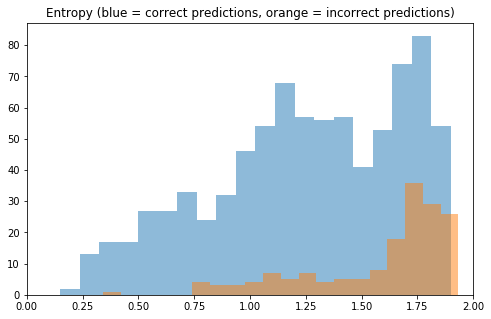

In [142]:
# The amount we are wrong for each example: 
# max predicted (wrong) class probability - the correct class probability
# amt_wrong = y_hat_wrong.max(dim=1)[0] - (y_wrong_onehot * y_hat_wrong).sum(dim=1)

entropy_wrong = -(y_hat_wrong * torch.log(y_hat_wrong)).sum(dim=1)
entropy_right = -(y_hat_right * torch.log(y_hat_right)).sum(dim=1)
plt.hist(entropy_right.detach().cpu().numpy(), bins=20, alpha=0.5)
plt.hist(entropy_wrong.detach().cpu().numpy(), bins=20, alpha=0.5)
plt.xlim(0.0,2.0)
plt.title('Entropy (blue = correct predictions, orange = incorrect predictions)')
plt.show()
# plt.hist(amt_wrong.detach().cpu().numpy(), bins=20)


In [280]:
# # Create connections to nodes
# adj_vec =  torch.eye(adj.shape[0])[(labels == c).nonzero()[0:5]].sum(dim=0).squeeze() # 5 from class 5
# adj_vec += torch.eye(adj.shape[0])[(labels == k).nonzero()[0:1]].sum(dim=0).squeeze() # 5 from class 5
# adj_vec = torch.cat((adj_vec, torch.ones(1)))
# adj_vec = (adj_vec / adj_vec.sum()).reshape(-1,1)

# # Modify adjacency matrix
# adj_ood = adj.to_dense()
# adj_ood = torch.cat((torch.cat((adj_ood, adj_vec[:-1]), dim=1), adj_vec.t()), dim=0)
# adj_ood = dense_to_sparse(adj_ood)len(idx_test)

In [360]:
# # Synthetic
# synthetic = [[1,1,1,1,1,1],
#              [1,1,0,0,0,0],
#              [1,0,1,0,0,0],
#              [1,0,0,1,0,0],
#              [1,0,0,0,1,0],
#              [1,0,0,0,0,1],]
# synthetic = torch.FloatTensor(synthetic)
# synthetic = synthetic / synthetic.sum(dim=1, keepdim=True)
# synthetic = dense_to_sparse(synthetic)

# # Modify features
# neighbor_feats  = feats[labels == n].mean(dim=0, keepdim=True)
# node_feats      = feats[labels == m].mean(dim=0, keepdim=True)
# synthetic_feats = [node_feats] + [neighbor_feats for _ in range(5)]
# synthetic_feats = torch.cat(synthetic_feats, dim=0)
